# Introduction

*In this challenge you will be asked to build a deep learning solution capable of segmenting turtles on synthetic images. You will be provided with the data, which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

The training data will consist of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Feel free to increase the dataset size as needed and make any relevant changes to the dataset creation.

Each image will come with the ground truth per-pixel segmentation mask which you can leverage for your training setup. We strongly recommend that you treat the provided task as semantic segmentation with 2 classes -- foreground (turtle) and background (everything else).

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image without the provided GT.

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a deep learning model capable of accurately segmenting the turtle in the test image.
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a **convex hull** (not concave), i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. Implement an algorithm that calculates the area of the polygon from the result of task 2.

*** Do not use model abstraction libraries such as TIMM, Transformers, or the models from TorchVision to create your segmentation model. You should use the PyTorch API to create a torch.nn.Module subclass defining your model.***

***Rules***

* Please use PyTorch to train your model in task 1.
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.
* You may modify any provided code, please provide explanation for any significant changes.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We must be able to reproduce your results by running the notebook in the browser as is. Be careful not to use too much RAM (12G) or GPU (15G) so it does not crash. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Grading Criteria***

* Output must be correct for all 3 tasks
* Should run in reasonable time without significant inefficiencies. Ideally < 10 minutes, training can take a little longer if needed.
* Code should be clean and readable

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [ ]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [ ]:
# Used to download any files you need for your solution from Google Drive
import gdown
!gdown --fuzzy https://drive.google.com/file/d/1sSV-hnN0BNCcWJl75eafpXvO17_88Z0x/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=1sSV-hnN0BNCcWJl75eafpXvO17_88Z0x
To: /content/turtle.png
100% 692k/692k [00:00<00:00, 137MB/s]


In [ ]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


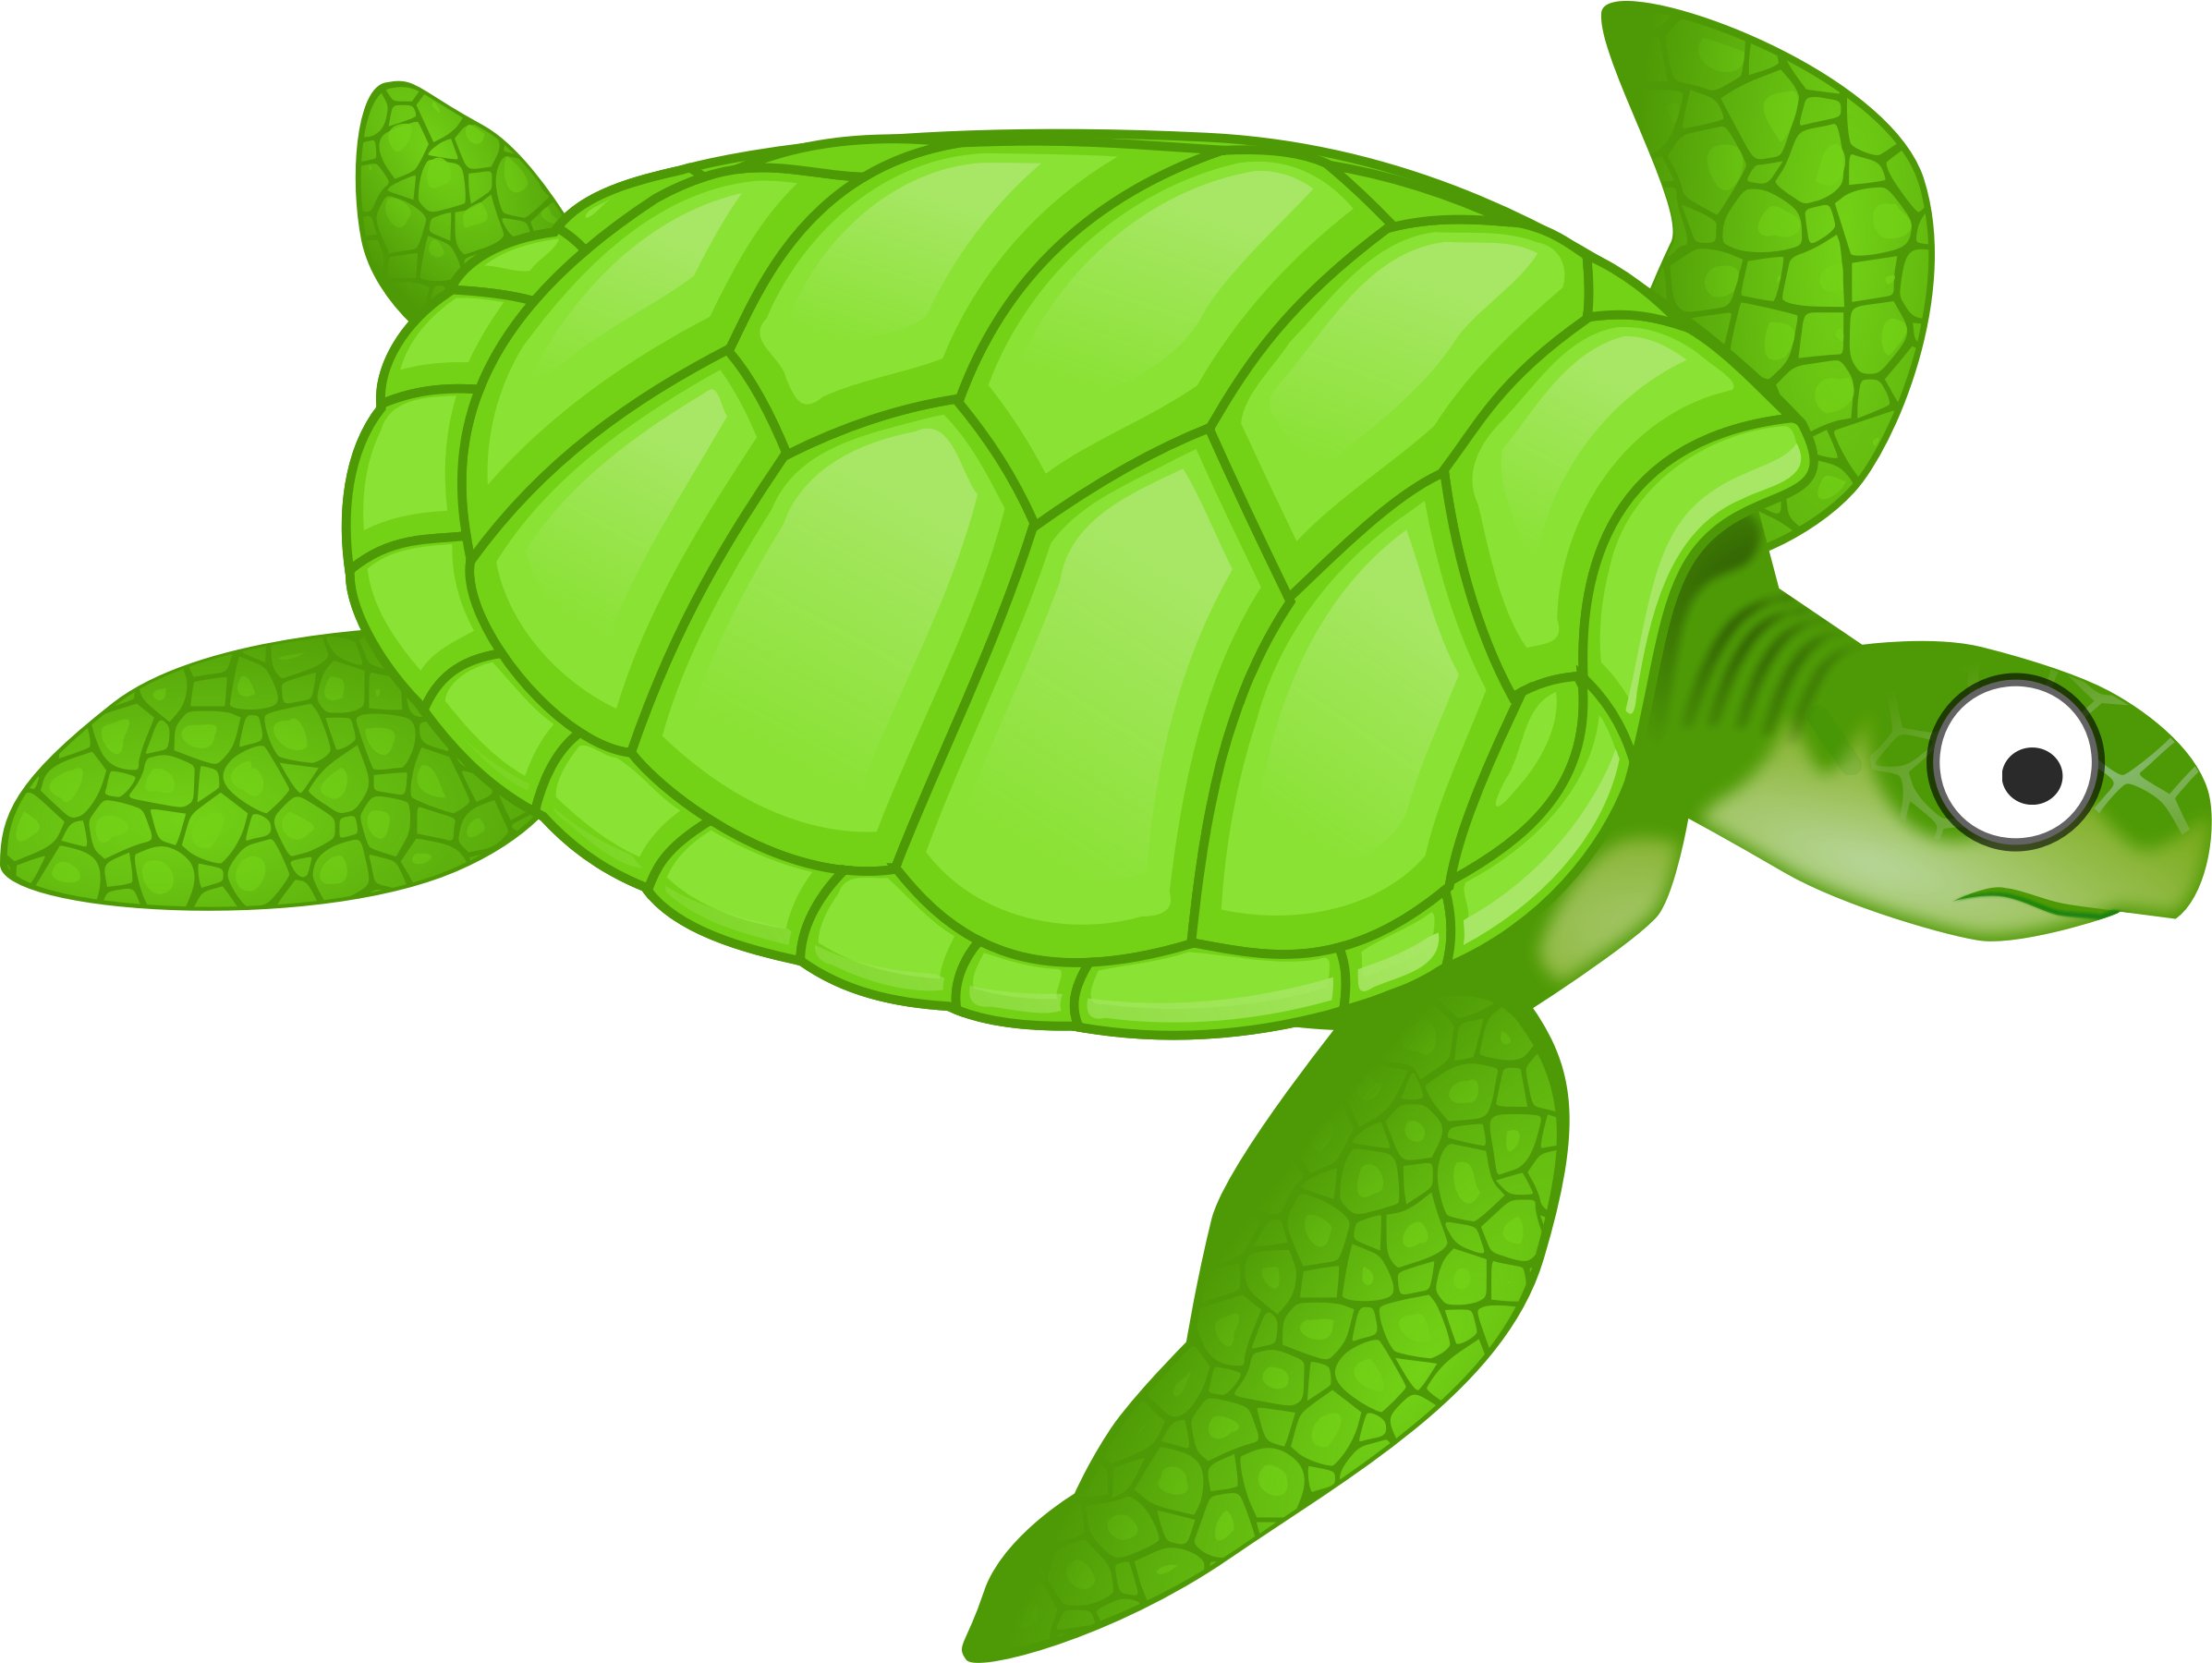

In [ ]:
turtle_image

In [ ]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images

In [ ]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
!pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [ ]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 10
batch_size = 3

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

100%|██████████| 715/715 [00:00<00:00, 1510794.64B/s]


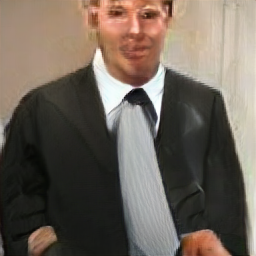

In [ ]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""

    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)

    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

In [ ]:
training_set = []  # image, segmentation mask

for background_image in background_images:
  # paste the turtle onto background image
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      tensor_transform(aug_image)[:3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      tensor_transform(aug_mask)[-1:] > 0,
  ]
  training_set.append(training_pair)

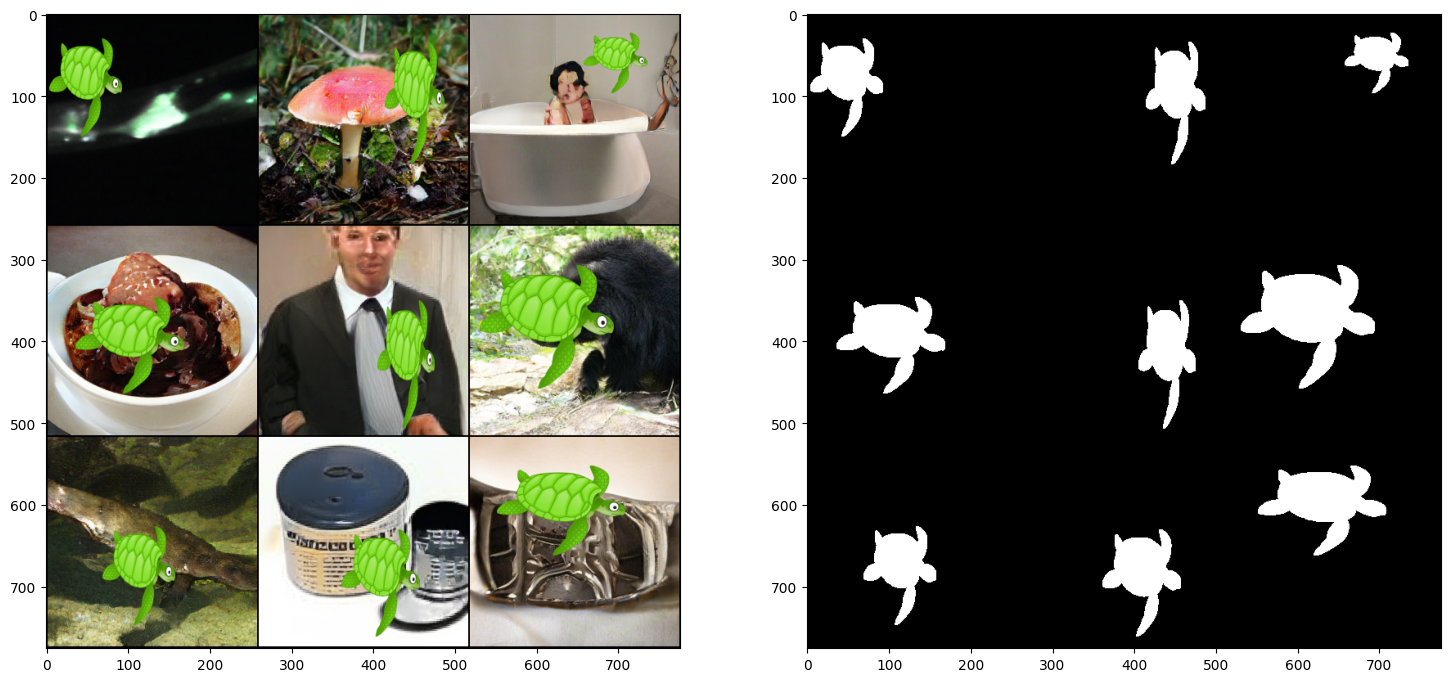

In [ ]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)

plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/17T9JbMCcih5SR0DtBeF9Q0aK11vUhxtG/view?usp=drive_link

Downloading...
From: https://drive.google.com/uc?id=17T9JbMCcih5SR0DtBeF9Q0aK11vUhxtG
To: /content/test.png
100% 413k/413k [00:00<00:00, 139MB/s]


RGB (512, 512)


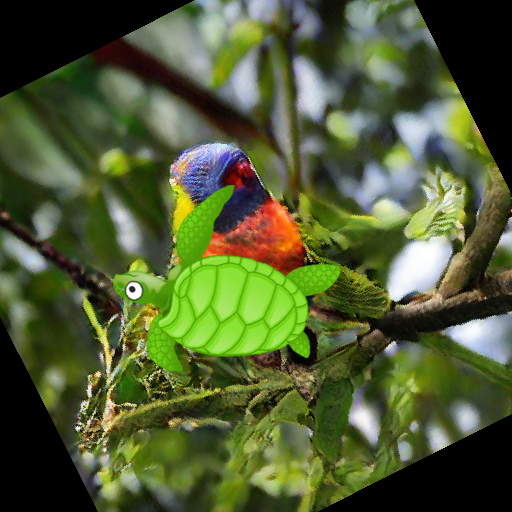

In [ ]:
test_image = Image.open('test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach must output a result at the native 512x512 resolution of the test image.*

In [ ]:
#TODO Part(Poojan) : Dataset information
image = training_set[0][0]
mask = training_set[0][1]
print(image.shape)
print(mask.shape)
print(mask.dtype)

# ok so the learning problem is
# input is RGB image [3,256,256] as x
# output is mask [1,256,256] as y
# binary pixewise segementation (turtle vs background)
# model output perpixel probabilty of turtle

# now as we want a dataloader to load the data
from  torch.utils.data import dataloader
train_loader = dataloader.DataLoader(
    training_set,
    batch_size = 4,
    shuffle = True
)
# sanity check
images,mask = next(iter(train_loader))
print(images.shape)
print(mask.shape)


torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.bool
torch.Size([4, 3, 256, 256])
torch.Size([4, 1, 256, 256])


In [ ]:
#This section is added later to introduce more generalized training as our dataset includes small amount of image
#Data augmentation
from torchvision.transforms.v2 import functional as f
from torch.utils.data import Dataset
class SegmentationAugmentation:
  def __init__(self, train = True,size=(256,256)):
    self.train = train
    self.size = size

    #first augmentation we want to apply is photometric
    self.color = transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.05)
    self.blur = transforms.GaussianBlur(kernel_size=3,sigma=(0.1,1.0))

  def  __call__(self,img,mask):

    img = f.resize(img,self.size,interpolation=transforms.InterpolationMode.BILINEAR,antialias=True)
    mask = f.resize(mask,self.size,interpolation=transforms.InterpolationMode.NEAREST)

    if not self.train:
      return img,mask
    # Geo metric augmentations
    if torch.rand(1) < 0.5:
      img = f.horizontal_flip(img)
      mask = f.horizontal_flip(mask)

    #random rotation
    angle = float(torch.empty(1).uniform_(-10,10))
    img = f.rotate(img,angle,interpolation = transforms.InterpolationMode.BILINEAR)
    mask = f.rotate(mask,angle,interpolation = transforms.InterpolationMode.NEAREST)

    #random resized crop (zoom in /out)
    i,j,h,w = transforms.RandomResizedCrop.get_params(img,scale=(0.75,1.0),ratio=(0.9,1.1))
    img = f.resized_crop(img,i,j,h,w,self.size,interpolation = transforms.InterpolationMode.BILINEAR)
    mask = f.resized_crop(mask,i,j,h,w,self.size,interpolation = transforms.InterpolationMode.NEAREST)

    #photometric augmentation
    if torch.rand(1) < 0.5:
      img = self.color(img)
    if torch.rand(1) < 0.2:
      img = self.blur(img)

    # make sure mask remains binary
    mask = (mask > 0.5).to(mask.dtype)
    return img,mask
class AugmentedSegDataset(Dataset):
  def __init__(self,base_ds,augment):
    self.base_ds = base_ds
    self.augment = augment
  def __len__(self):
    return len(self.base_ds)
  def __getitem__(self,idx):
    img,mask = self.base_ds[idx]
    img,mask = self.augment(img,mask)
    return img,mask


In [ ]:
# TODO: Implement and train the deep model

import torch.nn as nn
import torch.nn.functional as F

#Now moving the model design we must understadnt the requirements
#for the semantic segmentation we must keep the spatial information and global context
# if we use to much downsampling in our network we can loose the boundry details
# also on the other side we must decide if the given pixel is turtle or not so we
# must use filters which are not too much shallow
# also we cannnot use much bigger model because of tiny data
# so an encoder-decoder pattern must be well with U-net architecture,let us start with
# small which also consist of skip connections for sharp boundires
class ConvBlock(nn.Module):
  def __init__(self, in_ch,out_ch):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch,out_ch,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
    )
  def forward(self,x):
    return self.net(x)
class TinyUnet(nn.Module):
  def __init__(self,in_channels=3,base=32):
    super().__init__()
    self.enc1 = ConvBlock(in_channels,base)
    self.enc2 = ConvBlock(base,2*base)
    self.enc3 = ConvBlock(2*base,4*base)

    self.pool = nn.MaxPool2d(2)

    self.bottleneck = ConvBlock(base*4, base*8)
    self.up3 = nn.ConvTranspose2d(base*8, base*4, kernel_size=2, stride=2)
    self.dec3 = ConvBlock(base*8, base*4)           # concat skip

    self.up2 = nn.ConvTranspose2d(base*4, base*2, kernel_size=2, stride=2)
    self.dec2 = ConvBlock(base*4, base*2)

    self.up1 = nn.ConvTranspose2d(base*2, base, kernel_size=2, stride=2)
    self.dec1 = ConvBlock(base*2, base)

    # 1-channel logits for BCEWithLogitsLoss
    self.head = nn.Conv2d(base, 1, kernel_size=1)
  def forward(self, x):
      # encoder
      s1 = self.enc1(x)
      x = self.pool(s1)

      s2 = self.enc2(x)
      x = self.pool(s2)

      s3 = self.enc3(x)
      x = self.pool(s3)

      # Bottleneck
      x = self.bottleneck(x)

      # Decoder (crop/pad-safe via interpolation if needed)
      x = self.up3(x)
      if x.shape[-2:] != s3.shape[-2:]:
          x = F.interpolate(x, size=s3.shape[-2:], mode="bilinear", align_corners=False)
      x = torch.cat([x, s3], dim=1)
      x = self.dec3(x)

      x = self.up2(x)
      if x.shape[-2:] != s2.shape[-2:]:
          x = F.interpolate(x, size=s2.shape[-2:], mode="bilinear", align_corners=False)
      x = torch.cat([x, s2], dim=1)
      x = self.dec2(x)

      x = self.up1(x)
      if x.shape[-2:] != s1.shape[-2:]:
          x = F.interpolate(x, size=s1.shape[-2:], mode="bilinear", align_corners=False)
      x = torch.cat([x, s1], dim=1)
      x = self.dec1(x)

      return self.head(x)  # logits: (B,1,H,W)


In [ ]:
####### Sanity check ################
# model.train()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# image , mask = next(iter(train_loader))
# mask = mask.float()
# optimizer.zero_grad()
# logits = model(image)
# loss = criterion(logits,mask)
# print("loss:", loss.item())
# loss.backward()
# print("grad head:", model.head.weight.grad.abs().mean().item())
# optimizer.step()

#Test architecture
model = TinyUnet(in_channels=3, base=32)

x256 = torch.randn(2, 3, 256, 256)
y256 = model(x256)
print("256 ->", y256.shape)

x512 = torch.randn(1, 3, 512, 512)
y512 = model(x512)
print("512 ->", y512.shape)



# 1. we will start with the designing the loss to determine the output
# as we have a binary classification we will got with BCEloss and require the
# prob of each pixel wether it belongs to the turtle or not, we will use BCEloss
# with the logits
# criterion = nn.BCEWithLogitsLoss()
# num_epochs = 5
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# single = [training_set[0]] * 8
# single_loader = dataloader.DataLoader(single,batch_size=2,shuffle= True)
# for epoch in range(num_epochs):
#     model.train()
#     total_loss = 0.0
#     for images, masks in train_loader:
#         masks = masks.float()
#         optimizer.zero_grad()
#         logits = model(images)
#         loss = criterion(logits, masks)
#         total_loss += loss.item()
#     model.eval()
#     with torch.no_grad():
#       images,masks = next(iter(train_loader))
#       masks = masks.float()
#       logits = model(images)
#       dice = dice_score(logits,masks)
#     print(f"epoch {epoch+1}/{num_epochs} | loss {total_loss/len(train_loader):.4f} | dice {dice:.4f}")

#after running for few epochs we have realized that the loss and dice are not imporoving the reason behing that is
# tiny dataset 30 images only and the major pixel value covered by the backround pixels , to encounter that problem
# we have introduced the pos weight in BCE loss to punish model more on wrongly detecting the turtle pixel as backround
# pixel if that solves our problem that is fine, otherwise we will introduce the data augementation

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Model
model = TinyUnet(in_channels=3, base=32)

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    inter = (probs * targets).sum(dim=(0,2,3))
    union = probs.sum(dim=(0,2,3)) + targets.sum(dim=(0,2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()

def dice_score(model, loader, thresh=0.5, eps=1e-6):
    model.eval()
    total_inter, total_union = 0.0, 0.0
    with torch.no_grad():
        for images, masks in loader:
            masks = masks.float()
            probs = torch.sigmoid(model(images))
            preds = (probs > thresh).float()
            total_inter += (preds * masks).sum().item()
            total_union += (preds.sum() + masks.sum()).item()
    return (2.0 * total_inter + eps) / (total_union + eps)

def eval_pred_stats(model, loader, thresh=0.5):
    model.eval()
    total_pred_fg = 0.0
    total_true_fg = 0.0
    total_pixels  = 0.0
    mean_prob = 0.0
    n_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            masks = masks.float()
            probs = torch.sigmoid(model(images))
            preds = (probs > thresh).float()

            total_pred_fg += preds.sum().item()
            total_true_fg += masks.sum().item()
            total_pixels  += masks.numel()
            mean_prob     += probs.mean().item()
            n_batches     += 1

    return {
        "pred_fg_ratio": total_pred_fg / total_pixels,
        "true_fg_ratio": total_true_fg / total_pixels,
        "mean_prob": mean_prob / max(n_batches, 1),
        "thresh": thresh
    }

# Class Balance
turtle_pixel = torch.tensor(0.0)
total_pixel = torch.tensor(0.0)
for _, m in training_set:
    m = m.float()
    turtle_pixel +=m.sum()
    total_pixel += m.numel()
background_pixel = total_pixel - turtle_pixel
bg_ratio = background_pixel / total_pixel
fg_ratio = turtle_pixel / total_pixel

print("foreground ratio:", fg_ratio.item())
print("backgraound ratio:",bg_ratio.item())
pos_weight = (background_pixel / turtle_pixel).clamp(max=30.0)


# Choose ONE of these:
# criterion = nn.BCEWithLogitsLoss()  # plain BCE
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # weighted BCE


n = len(training_set)
n_val = max(3, int(0.2 * n))   # at least 3 images in val
n_train = n - n_val

train_set, val_set = random_split(training_set, [n_train, n_val])
#initalize the aumgentation
train_aug = SegmentationAugmentation(train=True,size=(256,256))
val_aug = SegmentationAugmentation(train=False,size=(256,256))

train_set = AugmentedSegDataset(train_set,train_aug)
val_set = AugmentedSegDataset(val_set,val_aug)

img, mask = train_set[0]  # or training_set[0]
print("img shape:", img.shape, "mask shape:", mask.shape)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

val_loader   = DataLoader(val_set, batch_size=4, shuffle=False)

print(f"train size: {len(train_set)} | val size: {len(val_set)}")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

best_val = -1.0
best_state = None
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, masks in train_loader:
        masks = masks.float()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, masks) + 0.7 * dice_loss(logits, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / max(1, len(train_loader))
    train_d  = dice_score(model, train_loader, thresh=0.4)
    val_d    = dice_score(model, val_loader, thresh=0.4)

    if val_d > best_val:
        best_val = val_d
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    print(f"epoch {epoch+1}/{num_epochs} | loss {avg_loss:.4f} | train_dice {train_d:.4f} | val_dice {val_d:.4f}")

256 -> torch.Size([2, 1, 256, 256])
512 -> torch.Size([1, 1, 512, 512])
foreground ratio: 0.08789672702550888
backgraound ratio: 0.9121032953262329
img shape: torch.Size([3, 256, 256]) mask shape: torch.Size([1, 256, 256])
train size: 24 | val size: 6
epoch 1/30 | loss 1.5399 | train_dice 0.1851 | val_dice 0.1718
epoch 2/30 | loss 1.1330 | train_dice 0.1796 | val_dice 0.1718
epoch 3/30 | loss 1.0007 | train_dice 0.1854 | val_dice 0.1718
epoch 4/30 | loss 0.9328 | train_dice 0.3315 | val_dice 0.3224
epoch 5/30 | loss 0.8846 | train_dice 0.6037 | val_dice 0.5933
epoch 6/30 | loss 0.8362 | train_dice 0.7991 | val_dice 0.7768
epoch 7/30 | loss 0.8144 | train_dice 0.8853 | val_dice 0.8183
epoch 8/30 | loss 0.7775 | train_dice 0.8207 | val_dice 0.8188
epoch 9/30 | loss 0.7844 | train_dice 0.7843 | val_dice 0.7847
epoch 10/30 | loss 0.7697 | train_dice 0.8330 | val_dice 0.7486
epoch 11/30 | loss 0.7447 | train_dice 0.8805 | val_dice 0.7662
epoch 12/30 | loss 0.7247 | train_dice 0.8741 | val_d

In [ ]:
 # TODO: Save the model weights and upload them to Google Drive
from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/turtle_segmentation/best_tinyunet.pth"
torch.save(best_state, save_path)
print("Saved to:", save_path)

Mounted at /content/drive


NameError: name 'best_state' is not defined

Downloading...
From: https://drive.google.com/uc?id=1W6yePO1qCKuUHRGLbrqJYZnJKw7KStqL
To: /content/best_tinyunet.pth
100% 7.76M/7.76M [00:00<00:00, 360MB/s]


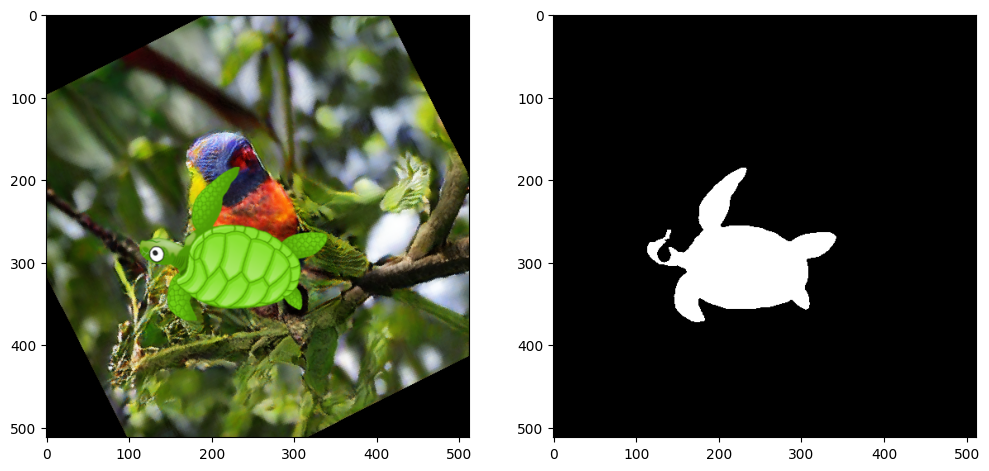

In [ ]:

load_model_weights = True
if load_model_weights:
    # After uploading your saved model weights to Google Drive, share to
    # "Anyone with the link" and extract FILE_ID from the share link
    # See https://support.google.com/drive/answer/2494822?hl=en&co=GENIE.Platform%3DDesktop
    # for more information
    # Now the weights can be downloaded and used via gdown:
    !gdown --fuzzy https://drive.google.com/file/d/1W6yePO1qCKuUHRGLbrqJYZnJKw7KStqL/view?usp=drive_link
# TODO: Load your saved model weights e.g. torch.load("saved_model.pth")
import numpy as np
from collections import deque

def keep_largest_component(mask_2d):
    """
    mask_2d: (H,W) array-like with values {0,1} (uint8/bool/int)
    returns: (H,W) uint8 mask with only the largest 4-connected component kept
    """
    mask = (np.asarray(mask_2d) > 0).astype(np.uint8)
    H, W = mask.shape
    seen = np.zeros((H, W), dtype=np.uint8)
    dirs = [(1,0), (-1,0), (0,1), (0,-1)]

    best_cells = []
    best_size = 0

    for r in range(H):
        for c in range(W):
            if mask[r, c] == 1 and seen[r, c] == 0:
                q = deque([(r, c)])
                seen[r, c] = 1
                cells = [(r, c)]

                while q:
                    y, x = q.popleft()
                    for dy, dx in dirs:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < H and 0 <= nx < W and mask[ny, nx] == 1 and seen[ny, nx] == 0:
                            seen[ny, nx] = 1
                            q.append((ny, nx))
                            cells.append((ny, nx))

                if len(cells) > best_size:
                    best_size = len(cells)
                    best_cells = cells

    out = np.zeros((H, W), dtype=np.uint8)
    for y, x in best_cells:
        out[y, x] = 1
    return out

model = TinyUnet(in_channels=3, base=32)
model.load_state_dict(torch.load("best_tinyunet.pth"))
model.eval()

test_image_tensor = tensor_transform(test_image)
x = test_image_tensor.float().unsqueeze(0)   # (1,3,512,512)

def get_mask_from_image(model, image_bchw, thresh=0.5):
    model.eval()
    with torch.no_grad():
        logits = model(image_bchw)                 # (1,1,512,512)
        probs  = torch.sigmoid(logits)[0, 0]       # (512,512)
        mask   = (probs > thresh).byte()           # (512,512)
    return mask, probs
# --- inference ---
test_mask_tensor, probs = get_mask_from_image(model, x, thresh=0.9)
test_mask_tensor = keep_largest_component(test_mask_tensor.numpy())
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(test_image_tensor.numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor, cmap="gray", vmin=0, vmax=1)
plt.show()

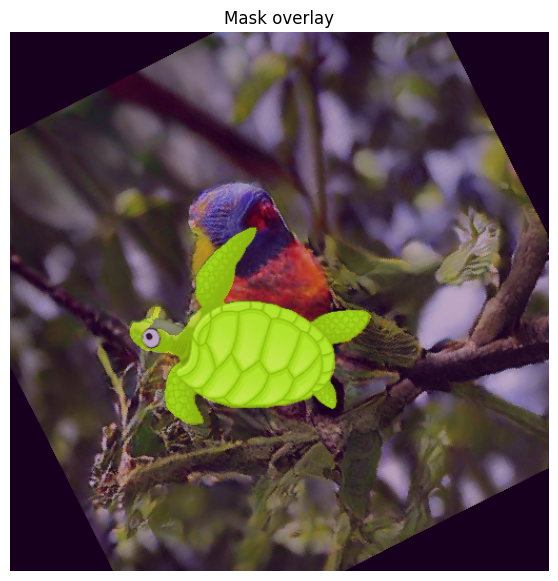

In [ ]:
img = test_image_tensor.permute(1,2,0).numpy()
mask = test_mask_tensor

import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.imshow(mask, alpha=0.35)
plt.title("Mask overlay")
plt.axis("off")
plt.show()


In [ ]:
#Evaluation of the model output
test_mask_tensor = torch.from_numpy(test_mask_tensor)
turtle_pixels = test_mask_tensor.sum().item()
total_pixels = test_mask_tensor.numel()
fg_ratio = turtle_pixels/total_pixels

print("Turtle ratio,:",fg_ratio)


from collections import deque

def largest_component_size(mask_image):
    dirs = [(0,1), (1,0), (-1,0), (0,-1)]
    seen = set()
    h, w = mask_image.shape
    best = 0

    def bfs(sr, sc):
        q = deque([(sr, sc)])
        seen.add((sr, sc))
        size = 0

        while q:
            r, c = q.popleft()
            size += 1

            for dr, dc in dirs:
                nr, nc = r + dr, c + dc
                if (0 <= nr < h and 0 <= nc < w and
                    mask_image[nr, nc] == 1 and (nr, nc) not in seen):
                    seen.add((nr, nc))
                    q.append((nr, nc))

        return size

    for r in range(h):
        for c in range(w):
            if mask_image[r, c] == 1 and (r, c) not in seen:
                best = max(best, bfs(r, c))

    return best

mask_np = test_mask_tensor.numpy()
largest = largest_component_size(mask_np)
total_fg = mask_np.sum()
print("largest_component / total_fg:", largest / max(int(total_fg), 1))


Turtle ratio,: 0.06817626953125
largest_component / total_fg: 1.0


# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a **convex hull** (not concave), an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based (using pixel coordinates) rather than image-based.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

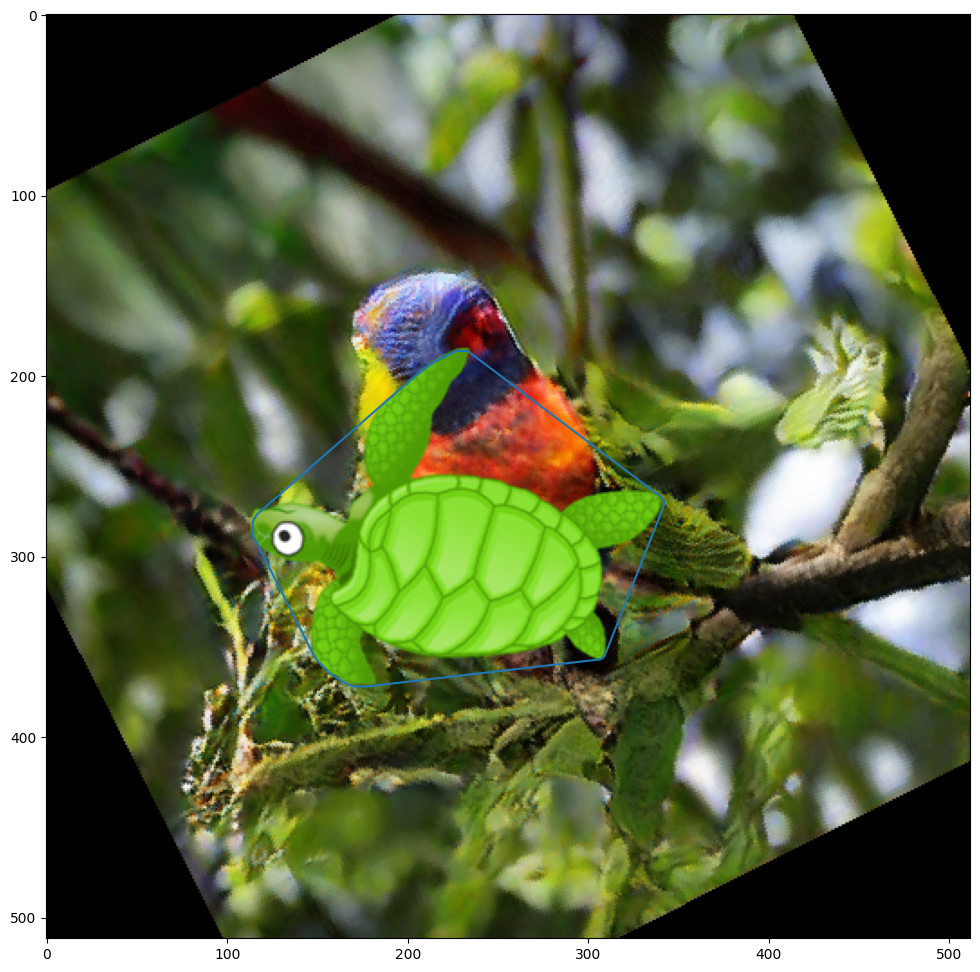

In [ ]:
import math
def get_tight_polygon_from_mask(test_mask):
  # TODO: Implement an algorithm that computes the enclosing polygon from the segmentation mask.
  # we are given the mask and to indentify the convex we must find out the boundry pixels
  # we can say that the boundry pixels should have some background pixels as neighbour
  row = test_mask.shape[0]
  col = test_mask.shape[1]
  boundry_points = []
  dirs = [(0,1),(1,0),(-1,0),(0,-1)]
  for i in range(row):
    for j in range(col):
      if  test_mask[i,j] == 1:
        #let us check there four neighbours
        for dr,dc in dirs:
          nr,nc = i+dr,j+dc
          if nr > 0 and nc > 0 and nr < row and nc < col and test_mask[nr,nc] == 0:
            boundry_points.append((j,i))
            break
    #now as we have the boundry pixels
    #we would need to find the left most pixel among this
  pivot = min(boundry_points,key = lambda x: (x[1],x[0]))

    # now to compare the points to find out the angle we would require to find the angle with reference to
    #pivot
  def angle(point):
    #slope
    diff_x = point[0]-pivot[0]
    diff_y = point[1]-pivot[1]
    return math.atan2(diff_y,diff_x)

  def dist2(p):
    dx = p[0] - pivot[0]
    dy = p[1] - pivot[1]
    return dx*dx + dy*dy

  sorted_pts = sorted(
    [p for p in boundry_points if p != pivot],
    key=lambda p: (angle(p), dist2(p)))

  def cross(a, b, c):
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])
  # now we have the points we will  use the stack to keep track of the most outside points
  mask_points_n2 = [pivot, sorted_pts[0], sorted_pts[1]]
  for p in sorted_pts[2:]:
    while len(mask_points_n2) >= 2 and cross(mask_points_n2[-2], mask_points_n2[-1], p) <= 0:
        mask_points_n2.pop()
    mask_points_n2.append(p)
  dummy_polygon_points_n2 = [(y, x) for (x, y) in mask_points_n2]
  return torch.tensor(dummy_polygon_points_n2)

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy())


polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)


# Task 3: Calculating the area of the polygon

<!-- > Indented block -->


*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than an image-based one.*

*You don't have to use PyTorch for this part. Your approach must output a result at the native 512x512 resolution of the test image.*

In [ ]:
def calculate_polygon_area(polygon_points_n2):
  # TODO: Implement the algorithm
  if polygon_points_n2.shape[0] < 3:
        return 0.0

  ys = polygon_points_n2[:, 0]
  xs = polygon_points_n2[:, 1]

  # Shoelace: 0.5 * |sum(x_i*y_{i+1} - y_i*x_{i+1})|
  x_next = torch.roll(xs, shifts=-1)
  y_next = torch.roll(ys, shifts=-1)

  area = (xs * y_next - ys * x_next).sum().abs()
  return (0.5 * area).item()


print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

Area = 28165.5000
